#About this notebook

Trial Run of mapping the sentiment data onto the stock data and turning it into a dataframe, which can be stored for later use such as Logistic and Granger.

In [0]:
!pip install alpha_vantage
!pip install vaderSentiment
!pip install googletrans

In [0]:
import tweepy
from tweepy import OAuthHandler
import datetime
import json
import csv
from pprint import pprint
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import re
import string
import seaborn as sns
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
from googletrans import Translator
translator = Translator()
from google.colab import drive
import statsmodels.tsa.stattools as ts

In [0]:
consumer_key= '__'
consumer_secret= '__'
access_token= '__'
access_token_secret= '__'

In [0]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                time.sleep(0.1)

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 
                    parsed_tweet['Date'] = tweet.created_at

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [0]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df_yeet = twitter_client.get_tweets('Apple', maxTweets=50000)
print(f'tweets_df Shape - {tweets_df_yeet.shape}')
tweets_df_yeet.tail(10)

In [0]:
tweets_df.describe()

,tweets,Date
count,10049,10049
unique,7249,9045
top,RT @charliebilello: Big tech returns in 2008 r...,2020-06-12 13:49:38
freq,260,5
first,NaN,2020-06-11 02:29:55
last,NaN,2020-06-14 15:20:32


In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")
    return lst

In [0]:
text_tweets=clean_tweets(tweets_df['tweets'].tolist())

In [0]:
text_tweets=text_tweets.tolist()

In [0]:
text_tweets

[' $SPY $AMD $BA  $ZM $SGMO $TSLA $SPCE $SNAP $WORK $NFLX $BYND  $AMD $IVR $DDOG $GILD $DKNG $PTON $ROKU $ORCL $FEYE $AAPL $…',
 ' $35k -&gt; $590k in 3 months\n\n\n\n$spx $spy $qqq $aapl $amzn $vix $vxx $uvxy',
 ' $spy $spx #SundayThoughts #RobinhoodTraders #RobinHood $qqq $ndx $aapl $amzn $twtr\n \n#redtogreen\n#3dayrally \n#stonksupmonday…',
 '$SPY $AMD $BA  $ZM $SGMO $TSLA $SPCE $SNAP $WORK $NFLX $BYND  $AMD $IVR $DDOG $GILD $DKNG $PTON $ROKU $ORCL $FEYE… ',
 ' watchOS 7 features: Everything we know ahead of WWDC 2020  $AAPL ',
 ' I Used To Get Rebutted\n\n$aapl $amzn $abbv $ba $bhc $crm $cmg $f $ge $hlf $iep $ibm $pep $ko $mcd $qsr $sbux $msft $fb…',
 ' $spy $spx #SundayThoughts #RobinhoodTraders #RobinHood $qqq $ndx $aapl $amzn  \n \nGap down tomorrow, a "not s…',
 '$35k -&gt; $590k in 3 months\n\n\n\n$spx $spy $qqq $aapl $amzn $vix $vxx $uvxy',
 " Pretty Shocking Video Of Police Abusing!  We Can't Have\nBad For Everyone &amp; Stocks! \n\n$aapl $amzn $abbv $ba $bhc $crm $cmg…",
 

In [0]:
def clean_tweet(tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) 
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [0]:
text_tweet=[]
for tweet in text_tweets:
  tweet__text=clean_tweet(tweet)
  tweet___text=remove_punct(tweet__text)

  #REMOVING VARIOUS SYMBOLS FROM TWEET TEXT
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  qwerty=(emoji_pattern.sub(r'', tweet___text)) # no emoji

  #for key1 in keywords_ext:
    #if (qwerty.find(key1) != -1):
  text_tweet.append(qwerty)

In [0]:
tweets_df['Cleaned tweets']=text_tweet

In [0]:
tweets_df.drop('tweets',axis=1,inplace=True)

In [0]:
tweets_df

,Date,Cleaned tweets
0,2020-06-14 15:20:32,SPY AMD BA ZM SGMO TSLA SPCE SNAP WORK NFLX BY...
1,2020-06-14 15:20:23,k gt k in months spx spy qqq aapl amzn vix vx...
2,2020-06-14 15:20:09,spy spx SundayThoughts RobinhoodTraders RobinH...
3,2020-06-14 15:19:59,SPY AMD BA ZM SGMO TSLA SPCE SNAP WORK NFLX BY...
4,2020-06-14 15:19:14,watchOS features Everything we know ahead of ...
...,...,...
10044,2020-06-11 02:30:42,GOOG AAPL SPY AMZN TDOC TSLA COST BA NFLX NVDA...
10045,2020-06-11 02:30:35,AMD AAPL TSLA FCEL MSFT BABA CHGG INSANE WINNE...
10046,2020-06-11 02:30:21,June Plan Click on Picture to Expand ESF SPX ...
10047,2020-06-11 02:30:03,Latest Zeitgeist gainers up up up


In [0]:
xy=tweets_df['Date'].tolist()
dates=[]
times=[]
for z in xy:
  dates.append(z.date())
  times.append(z.time())

In [0]:
type(dates[0])

datetime.date

In [0]:
tweets_df.drop('Date', axis=1, inplace=True)
tweets_df['Date']=dates
tweets_df['Time']=times

In [0]:
tweets_df

,Cleaned tweets,Date,Time
0,SPY AMD BA ZM SGMO TSLA SPCE SNAP WORK NFLX BY...,2020-06-14,15:20:32
1,k gt k in months spx spy qqq aapl amzn vix vx...,2020-06-14,15:20:23
2,spy spx SundayThoughts RobinhoodTraders RobinH...,2020-06-14,15:20:09
3,SPY AMD BA ZM SGMO TSLA SPCE SNAP WORK NFLX BY...,2020-06-14,15:19:59
4,watchOS features Everything we know ahead of ...,2020-06-14,15:19:14
...,...,...,...
10044,GOOG AAPL SPY AMZN TDOC TSLA COST BA NFLX NVDA...,2020-06-11,02:30:42
10045,AMD AAPL TSLA FCEL MSFT BABA CHGG INSANE WINNE...,2020-06-11,02:30:35
10046,June Plan Click on Picture to Expand ESF SPX ...,2020-06-11,02:30:21
10047,Latest Zeitgeist gainers up up up,2020-06-11,02:30:03


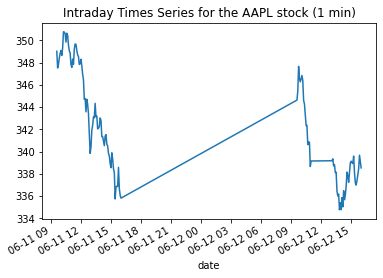

In [0]:
#ALPHA-VANTAGE INTRADAY STOCK DATA: 1MIN INTERVAL

ts = TimeSeries(key='2ZJEXZ6IRC95SZHM', output_format='pandas')
data, meta_data = ts.get_intraday(symbol='AAPL',interval='5min', outputsize='full')
data['4. close'].head(n=131).plot()
plt.title('Intraday Times Series for the AAPL stock (1 min)')
plt.show()

In [0]:
#type(data.index[0])
ab=data.head(131).index.tolist()
dates_1=[]
times_1=[]
for c in ab:
  dates_1.append(c.date())
  times_1.append(c.time())

In [0]:
dates_1

In [0]:
stock_prices=data.head(131)

In [0]:
stock_prices.drop('1. open', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
stock_prices['Date']=dates_1
stock_prices['Time']=times_1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
stock_prices

,4. close,Date,Time
date,,,
2020-06-12 16:00:00,338.5300,2020-06-12,16:00:00
2020-06-12 15:55:00,339.1100,2020-06-12,15:55:00
2020-06-12 15:50:00,339.6700,2020-06-12,15:50:00
2020-06-12 15:45:00,338.4400,2020-06-12,15:45:00
2020-06-12 15:40:00,337.8876,2020-06-12,15:40:00
...,...,...,...
2020-06-11 09:55:00,348.8100,2020-06-11,09:55:00
2020-06-11 09:50:00,348.4001,2020-06-11,09:50:00
2020-06-11 09:45:00,347.8375,2020-06-11,09:45:00


In [0]:
tweets_df

,Cleaned tweets,Date,Time
0,ProfitPacked Option Trades YearlyDelivered to...,2020-06-14,11:03:26
1,Gospel radio host gunned down in Baltimore AAP...,2020-06-14,11:03:23
2,ProfitPacked Option Trades YearlyDelivered to...,2020-06-14,11:01:14
3,USOIL Hit TP within minutes since fundamental ...,2020-06-14,10:58:42
4,Gospel radio host gunned down in Baltimore AAP...,2020-06-14,10:58:37
...,...,...,...
10047,Awesome wins today on NFLX and NOW Join today...,2020-06-11,00:21:31
10048,Top increases in users holding for stocks held...,2020-06-11,00:21:28
10049,Day In Review off st month on all plans unti...,2020-06-11,00:21:20
10050,AAPL AAPL chart,2020-06-11,00:21:06


In [0]:
qwer=tweets_df['Date'].to_list()[0]
qwer

datetime.date(2020, 6, 14)

In [0]:
tweets_df_r123=tweets_df[(tweets_df['Date']==datetime.date(2020, 6, 11))]

In [0]:
tweets_df_r1

,Cleaned tweets,Date,Time,SentimentScore
0,Options Flow Grid Update AAPL OptionsTrading A...,2020-06-12,23:59:06,0.2960
1,Sharia Law Next aapl amzn abbv brk bhc ba cat ...,2020-06-12,23:58:28,0.0000
2,EURNZD TP Hit PIPS PROFIT ⚡️ Checkout the Bio...,2020-06-12,23:56:47,0.5622
3,Apple leaker suggests inch MacBook refresh cou...,2020-06-12,23:53:33,0.0000
4,That AAPL stock took a slight hit these past ...,2020-06-12,23:53:00,-0.5927
...,...,...,...,...
8087,Awesome wins today on NFLX and NOW Join today...,2020-06-11,00:21:31,0.9217
8088,Top increases in users holding for stocks held...,2020-06-11,00:21:28,0.2023
8089,Day In Review off st month on all plans unti...,2020-06-11,00:21:20,0.0000
8090,AAPL AAPL chart,2020-06-11,00:21:06,0.0000


In [0]:
analyser = SentimentIntensityAnalyzer()
scores = []
text_tweet=tweets_df_r1['Cleaned tweets'].tolist()
def sentiment_analyzer_scores(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text).text
    score = analyser.polarity_scores(trans)
    lb = score['compound']
    return lb
scores=[]
for x in text_tweet:
  sentiment_score = sentiment_analyzer_scores(x)
  scores.append(sentiment_score)

In [0]:
tweets_df_r1['SentimentScore']=scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
tweets_df_r1

,Cleaned tweets,Date,Time,SentimentScore
0,Options Flow Grid Update AAPL OptionsTrading A...,2020-06-12,23:59:06,0.2960
1,Sharia Law Next aapl amzn abbv brk bhc ba cat ...,2020-06-12,23:58:28,0.0000
2,EURNZD TP Hit PIPS PROFIT ⚡️ Checkout the Bio...,2020-06-12,23:56:47,0.5622
3,Apple leaker suggests inch MacBook refresh cou...,2020-06-12,23:53:33,0.0000
4,That AAPL stock took a slight hit these past ...,2020-06-12,23:53:00,-0.5927
...,...,...,...,...
8087,Awesome wins today on NFLX and NOW Join today...,2020-06-11,00:21:31,0.9217
8088,Top increases in users holding for stocks held...,2020-06-11,00:21:28,0.2023
8089,Day In Review off st month on all plans unti...,2020-06-11,00:21:20,0.0000
8090,AAPL AAPL chart,2020-06-11,00:21:06,0.0000


In [0]:
asda=[]
for u in range(8092):
  asda.append(u)
tweets_df_r1.index=asda

In [0]:
tweets_df_r1

,Cleaned tweets,Date,Time,SentimentScore
0,Options Flow Grid Update AAPL OptionsTrading A...,2020-06-12,23:59:06,0.2960
1,Sharia Law Next aapl amzn abbv brk bhc ba cat ...,2020-06-12,23:58:28,0.0000
2,EURNZD TP Hit PIPS PROFIT ⚡️ Checkout the Bio...,2020-06-12,23:56:47,0.5622
3,Apple leaker suggests inch MacBook refresh cou...,2020-06-12,23:53:33,0.0000
4,That AAPL stock took a slight hit these past ...,2020-06-12,23:53:00,-0.5927
...,...,...,...,...
8087,Awesome wins today on NFLX and NOW Join today...,2020-06-11,00:21:31,0.9217
8088,Top increases in users holding for stocks held...,2020-06-11,00:21:28,0.2023
8089,Day In Review off st month on all plans unti...,2020-06-11,00:21:20,0.0000
8090,AAPL AAPL chart,2020-06-11,00:21:06,0.0000


In [0]:
import datetime
karen={}
tweets_df_r1_2=tweets_df_r1[(tweets_df_r1['Date']==datetime.date(2020, 6, 12))]
tweet_timeline1=tweets_df_r1_2['Time'].tolist()
stock_prices1=stock_prices[stock_prices['Date']==datetime.date(2020, 6, 12)]
stock_timeline1=stock_prices1['Time'].tolist()

from datetime import datetime
for x in range(len(stock_timeline1)):
  seconds_dif=[]
  a=str(stock_timeline1[x])
  for y in range(len(tweet_timeline1)):
    b=str(tweet_timeline1[y])
    FMT = '%H:%M:%S'
    t1delta = datetime.strptime(a, FMT) - datetime.strptime(b, FMT)
    secs=t1delta.total_seconds()
    seconds_dif.append(secs)
  karen[':'+a]=seconds_dif

In [0]:
sass=pd.DataFrame(data=karen)

In [0]:
sass

,:16:00:00,:15:55:00,:15:50:00,:15:45:00,:15:40:00,:15:35:00,:15:30:00,:15:25:00,:15:20:00,:15:15:00,:15:10:00,:15:05:00,:15:00:00,:14:55:00,:14:50:00,:14:45:00,:14:40:00,:14:35:00,:14:30:00,:14:25:00,:14:20:00,:14:15:00,:14:10:00,:14:05:00,:14:00:00,:13:55:00,:13:50:00,:13:45:00,:13:40:00,:13:35:00,:13:30:00,:13:25:00,:13:20:00,:13:15:00,:13:10:00,:13:05:00,:11:00:00,:10:55:00,:10:50:00,:10:45:00,:10:40:00,:10:35:00,:10:30:00,:10:20:00,:10:15:00,:10:10:00,:10:05:00,:10:00:00,:09:55:00,:09:50:00,:09:45:00,:09:40:00,:09:35:00
0,-28746.0,-29046.0,-29346.0,-29646.0,-29946.0,-30246.0,-30546.0,-30846.0,-31146.0,-31446.0,-31746.0,-32046.0,-32346.0,-32646.0,-32946.0,-33246.0,-33546.0,-33846.0,-34146.0,-34446.0,-34746.0,-35046.0,-35346.0,-35646.0,-35946.0,-36246.0,-36546.0,-36846.0,-37146.0,-37446.0,-37746.0,-38046.0,-38346.0,-38646.0,-38946.0,-39246.0,-46746.0,-47046.0,-47346.0,-47646.0,-47946.0,-48246.0,-48546.0,-49146.0,-49446.0,-49746.0,-50046.0,-50346.0,-50646.0,-50946.0,-51246.0,-51546.0,-51846.0
1,-28708.0,-29008.0,-29308.0,-29608.0,-29908.0,-30208.0,-30508.0,-30808.0,-31108.0,-31408.0,-31708.0,-32008.0,-32308.0,-32608.0,-32908.0,-33208.0,-33508.0,-33808.0,-34108.0,-34408.0,-34708.0,-35008.0,-35308.0,-35608.0,-35908.0,-36208.0,-36508.0,-36808.0,-37108.0,-37408.0,-37708.0,-38008.0,-38308.0,-38608.0,-38908.0,-39208.0,-46708.0,-47008.0,-47308.0,-47608.0,-47908.0,-48208.0,-48508.0,-49108.0,-49408.0,-49708.0,-50008.0,-50308.0,-50608.0,-50908.0,-51208.0,-51508.0,-51808.0
2,-28607.0,-28907.0,-29207.0,-29507.0,-29807.0,-30107.0,-30407.0,-30707.0,-31007.0,-31307.0,-31607.0,-31907.0,-32207.0,-32507.0,-32807.0,-33107.0,-33407.0,-33707.0,-34007.0,-34307.0,-34607.0,-34907.0,-35207.0,-35507.0,-35807.0,-36107.0,-36407.0,-36707.0,-37007.0,-37307.0,-37607.0,-37907.0,-38207.0,-38507.0,-38807.0,-39107.0,-46607.0,-46907.0,-47207.0,-47507.0,-47807.0,-48107.0,-48407.0,-49007.0,-49307.0,-49607.0,-49907.0,-50207.0,-50507.0,-50807.0,-51107.0,-51407.0,-51707.0
3,-28413.0,-28713.0,-29013.0,-29313.0,-29613.0,-29913.0,-30213.0,-30513.0,-30813.0,-31113.0,-31413.0,-31713.0,-32013.0,-32313.0,-32613.0,-32913.0,-33213.0,-33513.0,-33813.0,-34113.0,-34413.0,-34713.0,-35013.0,-35313.0,-35613.0,-35913.0,-36213.0,-36513.0,-36813.0,-37113.0,-37413.0,-37713.0,-38013.0,-38313.0,-38613.0,-38913.0,-46413.0,-46713.0,-47013.0,-47313.0,-47613.0,-47913.0,-48213.0,-48813.0,-49113.0,-49413.0,-49713.0,-50013.0,-50313.0,-50613.0,-50913.0,-51213.0,-51513.0
4,-28380.0,-28680.0,-28980.0,-29280.0,-29580.0,-29880.0,-30180.0,-30480.0,-30780.0,-31080.0,-31380.0,-31680.0,-31980.0,-32280.0,-32580.0,-32880.0,-33180.0,-33480.0,-33780.0,-34080.0,-34380.0,-34680.0,-34980.0,-35280.0,-35580.0,-35880.0,-36180.0,-36480.0,-36780.0,-37080.0,-37380.0,-37680.0,-37980.0,-38280.0,-38580.0,-38880.0,-46380.0,-46680.0,-46980.0,-47280.0,-47580.0,-47880.0,-48180.0,-48780.0,-49080.0,-49380.0,-49680.0,-49980.0,-50280.0,-50580.0,-50880.0,-51180.0,-51480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,57380.0,57080.0,56780.0,56480.0,56180.0,55880.0,55580.0,55280.0,54980.0,54680.0,54380.0,54080.0,53780.0,53480.0,53180.0,52880.0,52580.0,52280.0,51980.0,51680.0,51380.0,51080.0,50780.0,50480.0,50180.0,49880.0,49580.0,49280.0,48980.0,48680.0,48380.0,48080.0,47780.0,47480.0,47180.0,46880.0,39380.0,39080.0,38780.0,38480.0,38180.0,37880.0,37580.0,36980.0,36680.0,36380.0,36080.0,35780.0,35480.0,35180.0,34880.0,34580.0,34280.0
3542,57382.0,57082.0,56782.0,56482.0,56182.0,55882.0,55582.0,55282.0,54982.0,54682.0,54382.0,54082.0,53782.0,53482.0,53182.0,52882.0,52582.0,52282.0,51982.0,51682.0,51382.0,51082.0,50782.0,50482.0,50182.0,49882.0,49582.0,49282.0,48982.0,48682.0,48382.0,48082.0,47782.0,47482.0,47182.0,46882.0,39382.0,39082.0,38782.0,38482.0,38182.0,37882.0,37582.0,36982.0,36682.0,36382.0,36082.0,35782.0,35482.0,35182.0,34882.0,34582.0,34282.0


In [0]:
karen2={}
for column in sass.columns:
  sas1=sass[(sass[column]<=150)&(sass[column]>=-150)]
  ab=sas1.index.tolist()
  karen2['sig'+str(column)]=ab

In [0]:
import datetime
tweets_df_r123=tweets_df[(tweets_df['Date']==datetime.date(2020, 6, 11))]

In [0]:
tweets_df_r1_2

,Cleaned tweets,Date,Time,SentimentScore
0,Options Flow Grid Update AAPL OptionsTrading A...,2020-06-12,23:59:06,0.2960
1,Sharia Law Next aapl amzn abbv brk bhc ba cat ...,2020-06-12,23:58:28,0.0000
2,EURNZD TP Hit PIPS PROFIT ⚡️ Checkout the Bio...,2020-06-12,23:56:47,0.5622
3,Apple leaker suggests inch MacBook refresh cou...,2020-06-12,23:53:33,0.0000
4,That AAPL stock took a slight hit these past ...,2020-06-12,23:53:00,-0.5927
...,...,...,...,...
3541,The FED that’s buying the market does not sit ...,2020-06-12,00:03:40,-0.3412
3542,SampP showing some position sizing footprints ...,2020-06-12,00:03:38,0.0000
3543,spy spx acb qqq nyse amzn aapl twtr nflx amd m...,2020-06-12,00:02:50,0.0000
3544,Futures open looking good for tomorrow may the...,2020-06-12,00:02:27,0.7650


In [0]:
indi=[]
abc={}
for x in range(3546):
  indi.append(x)
tweets_df_r1_2.index=indi
asdf=list(karen2.keys())
senscores=tweets_df_r1_2['SentimentScore'].tolist()
for keye in asdf:
  bc=karen2[keye]
  sur=0
  for inr in bc:
    sur=sur+senscores[inr]
  try:
    final_sum=sur/len(bc)
  except ZeroDivisionError:
    final_sum=0.0
  abc['f:'+keye]=final_sum


In [0]:
len(abc)

53

In [0]:
asp=[]
for i in range(53):
  asp.append(i)
bruh2=pd.DataFrame(data=abc, index=[0])

In [0]:
bruh2

,f:sig:16:00:00,f:sig:15:55:00,f:sig:15:50:00,f:sig:15:45:00,f:sig:15:40:00,f:sig:15:35:00,f:sig:15:30:00,f:sig:15:25:00,f:sig:15:20:00,f:sig:15:15:00,f:sig:15:10:00,f:sig:15:05:00,f:sig:15:00:00,f:sig:14:55:00,f:sig:14:50:00,f:sig:14:45:00,f:sig:14:40:00,f:sig:14:35:00,f:sig:14:30:00,f:sig:14:25:00,f:sig:14:20:00,f:sig:14:15:00,f:sig:14:10:00,f:sig:14:05:00,f:sig:14:00:00,f:sig:13:55:00,f:sig:13:50:00,f:sig:13:45:00,f:sig:13:40:00,f:sig:13:35:00,f:sig:13:30:00,f:sig:13:25:00,f:sig:13:20:00,f:sig:13:15:00,f:sig:13:10:00,f:sig:13:05:00,f:sig:11:00:00,f:sig:10:55:00,f:sig:10:50:00,f:sig:10:45:00,f:sig:10:40:00,f:sig:10:35:00,f:sig:10:30:00,f:sig:10:20:00,f:sig:10:15:00,f:sig:10:10:00,f:sig:10:05:00,f:sig:10:00:00,f:sig:09:55:00,f:sig:09:50:00,f:sig:09:45:00,f:sig:09:40:00,f:sig:09:35:00
0,0.052288,-0.002774,0.093333,-0.029178,-0.105534,-0.012907,-0.032225,0.062407,-0.111774,-0.004083,-0.02113,0.022991,0.080829,0.206944,0.180468,0.181086,0.073472,0.0414,0.051818,0.145753,0.10515,0.095608,0.082248,0.018595,-0.033747,0.084947,0.002344,0.117635,0.080923,0.051192,0.0588,0.068238,0.067517,0.140517,0.05368,0.205748,0.122413,0.127267,0.168275,0.16444,0.29485,-0.003558,-0.3525,0.158117,-0.2023,0.320333,-0.0477,0.0,0.2396,0.06364,-0.1531,0.0,0.096187


In [0]:
list(bruh2.columns)

In [0]:
df2 = bruh2.transpose()

In [0]:
df2['Sentiment Score']=df2[0]
df2['Time']=df2.index
df2.index=asp

In [0]:
df2.drop(0, axis=1, inplace=True)

In [0]:
df2

,Sentiment Score,Time
0,0.052288,f:sig:16:00:00
1,-0.002774,f:sig:15:55:00
2,0.093333,f:sig:15:50:00
3,-0.029178,f:sig:15:45:00
4,-0.105534,f:sig:15:40:00
5,-0.012907,f:sig:15:35:00
6,-0.032225,f:sig:15:30:00
7,0.062407,f:sig:15:25:00
8,-0.111774,f:sig:15:20:00
9,-0.004083,f:sig:15:15:00


In [0]:
Master_fin36=stock_prices1
Master_fin36['sentiment scores']=df2['Sentiment Score'].tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
Mastur_fin=pd.concat([Master_fin36, Master_fin34], ignore_index=True)

In [0]:
Mastur_fin

,4. close,Date,Time,sentiment scores
0,338.5300,2020-06-12,16:00:00,0.052288
1,339.1100,2020-06-12,15:55:00,-0.002774
2,339.6700,2020-06-12,15:50:00,0.093333
3,338.4400,2020-06-12,15:45:00,-0.029178
4,337.8876,2020-06-12,15:40:00,-0.105534
...,...,...,...,...
126,348.8100,2020-06-11,09:55:00,0.000000
127,348.4001,2020-06-11,09:50:00,0.004455
128,347.8375,2020-06-11,09:45:00,-0.122640
129,347.5100,2020-06-11,09:40:00,0.000000


In [0]:
x1=Mastur_fin['4. close'].tolist()
y1=Mastur_fin['sentiment scores'].tolist()
res=list(zip(x1,y1))
granger_result=ts.grangercausalitytests(res, maxlag=43)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0020  , p=0.9644  , df_denom=127, df_num=1
ssr based chi2 test:   chi2=0.0020  , p=0.9639  , df=1
likelihood ratio test: chi2=0.0020  , p=0.9639  , df=1
parameter F test:         F=0.0020  , p=0.9644  , df_denom=127, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0319  , p=0.9686  , df_denom=124, df_num=2
ssr based chi2 test:   chi2=0.0664  , p=0.9673  , df=2
likelihood ratio test: chi2=0.0664  , p=0.9673  , df=2
parameter F test:         F=0.0319  , p=0.9686  , df_denom=124, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3248  , p=0.8074  , df_denom=121, df_num=3
ssr based chi2 test:   chi2=1.0309  , p=0.7938  , df=3
likelihood ratio test: chi2=1.0267  , p=0.7948  , df=3
parameter F test:         F=0.3248  , p=0.8074  , df_denom=121, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5504  , p=0.6991  

In [0]:
asdfg=pd.DataFrame(data=granger_result)

In [0]:
asdfg

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,"{'ssr_ftest': (0.00200088269261356, 0.96439179...","{'ssr_ftest': (0.03192073331786993, 0.96859131...","{'ssr_ftest': (0.3248278084846996, 0.807403834...","{'ssr_ftest': (0.5503803839938463, 0.699099668...","{'ssr_ftest': (0.7420306727100245, 0.593538692...","{'ssr_ftest': (0.5646910249233459, 0.757616778...","{'ssr_ftest': (0.8663904655237962, 0.535567596...","{'ssr_ftest': (0.9559425219502403, 0.474463753...","{'ssr_ftest': (1.3864754280442864, 0.203819039...","{'ssr_ftest': (1.3072433523792961, 0.236962126...","{'ssr_ftest': (1.7820449232858557, 0.067466312...","{'ssr_ftest': (1.751052691430898, 0.0681503455...","{'ssr_ftest': (2.1235897549199665, 0.019724017...","{'ssr_ftest': (1.9771533933008267, 0.028687107...","{'ssr_ftest': (1.8031578523531708, 0.047198393...","{'ssr_ftest': (1.6855064511831175, 0.065952821...","{'ssr_ftest': (1.734158857837431, 0.0534722913...","{'ssr_ftest': (1.7556961114068443, 0.047507530...","{'ssr_ftest': (1.7321119715382085, 0.049764563...","{'ssr_ftest': (1.6051883079624731, 0.075966437...","{'ssr_ftest': (1.4820066804948957, 0.114480707...","{'ssr_ftest': (1.3944879282239457, 0.152288508...","{'ssr_ftest': (1.4003717046733926, 0.148653834...","{'ssr_ftest': (1.3460205786140658, 0.177693480...","{'ssr_ftest': (1.330980989518643, 0.1869478582...","{'ssr_ftest': (1.2554111674673132, 0.238590885...","{'ssr_ftest': (1.1890706758918317, 0.293144835...","{'ssr_ftest': (1.2931507531862663, 0.215449234...","{'ssr_ftest': (1.167527304619529, 0.3167664223...","{'ssr_ftest': (1.1547375065095797, 0.331497755...","{'ssr_ftest': (1.0456887078787565, 0.444709515...","{'ssr_ftest': (1.0378725696171587, 0.456415968...","{'ssr_ftest': (1.3281429492436665, 0.214811647...","{'ssr_ftest': (1.1962406593118724, 0.315950933...","{'ssr_ftest': (1.1008267166448402, 0.406788699...","{'ssr_ftest': (1.0569260027316285, 0.455366112...","{'ssr_ftest': (0.9064333168517562, 0.613351033...","{'ssr_ftest': (1.0869181130481986, 0.445482549...","{'ssr_ftest': (0.9648619624449212, 0.561322260...","{'ssr_ftest': (1.8865177881797337, 0.141517696...","{'ssr_ftest': (1.7838203454544244, 0.216817007...","{'ssr_ftest': (1.1840181994882204, 0.495065645...","{'ssr_ftest': (11.395604807943664, 0.231520704..."
1,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.Regressi...,[<statsmodels.regression.linear_model.R

In [0]:
aws=asdfg.iloc[0].to_frame()

In [0]:
aws['']

,0
1,"{'ssr_ftest': (0.00200088269261356, 0.96439179..."
2,"{'ssr_ftest': (0.03192073331786993, 0.96859131..."
3,"{'ssr_ftest': (0.3248278084846996, 0.807403834..."
4,"{'ssr_ftest': (0.5503803839938463, 0.699099668..."
5,"{'ssr_ftest': (0.7420306727100245, 0.593538692..."
6,"{'ssr_ftest': (0.5646910249233459, 0.757616778..."
7,"{'ssr_ftest': (0.8663904655237962, 0.535567596..."
8,"{'ssr_ftest': (0.9559425219502403, 0.474463753..."
9,"{'ssr_ftest': (1.3864754280442864, 0.203819039..."
10,"{'ssr_ftest': (1.3072433523792961, 0.236962126..."


In [0]:
drive.mount('drive')
aws.to_csv('granger_results.csv')
!cp granger_results.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
